# Ejercicios Clase 7

En este trabajo práctico, nos adentraremos en el fascinante mundo de los VAEs aplicándolos a la generación de imágenes de jugadores de fútbol. Utilizando un conjunto de datos que contiene imágenes de jugadores, construiremos y entrenaremos un modelo de autoencoder variacional que aprenderá a capturar las características esenciales de estas imágenes. Posteriormente, emplearemos el modelo entrenado para generar nuevas imágenes de jugadores, explorando la capacidad de los VAEs para crear contenido visual que no existía previamente.

## Dataset

Las siguientes celdas descargan el dataset de jugadores FIFA utilizado en la clase de GANs.

In [ ]:
!gdown https://drive.google.com/uc?id=1zpT6gHzvbr21_Vq4NjpRY0JGSaQOSANa
!unzip fifa.zip

In [1]:
import os
import torchvision
import torch
def remove_noise(image):
    alpha = image[3, :,:]> 50
    alpha = alpha.type(torch.uint8)
    noise_filtered = torch.mul(alpha, image)
    return noise_filtered[:3,:,:]

def read_voc_images(voc_dir, n=-1,  is_train=True):
    """Read all VOC feature and label images."""
    files = [os.path.join(voc_dir, file) for file in os.listdir(voc_dir)]
    #files = files.sort()
    files = sorted(files, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
    mode = torchvision.io.image.ImageReadMode.RGB_ALPHA
    features, labels = [], []
    for i, fname in enumerate(files):
        l = fname.split("/")
        if i==n: break
        try:
          img = remove_noise(torchvision.io.read_image(os.path.join(
            voc_dir, fname)))
        except:
          continue
        features.append(img)
        labels.append(int(l[-1][:-4]))
    return features, labels



In [2]:
import pandas as pd
data = pd.read_csv("data.csv")
f, l = read_voc_images("/content/Images")
names = list(data["Name"])

In [3]:
#@markdown función show_images
from matplotlib import pyplot as plt
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach().numpy()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

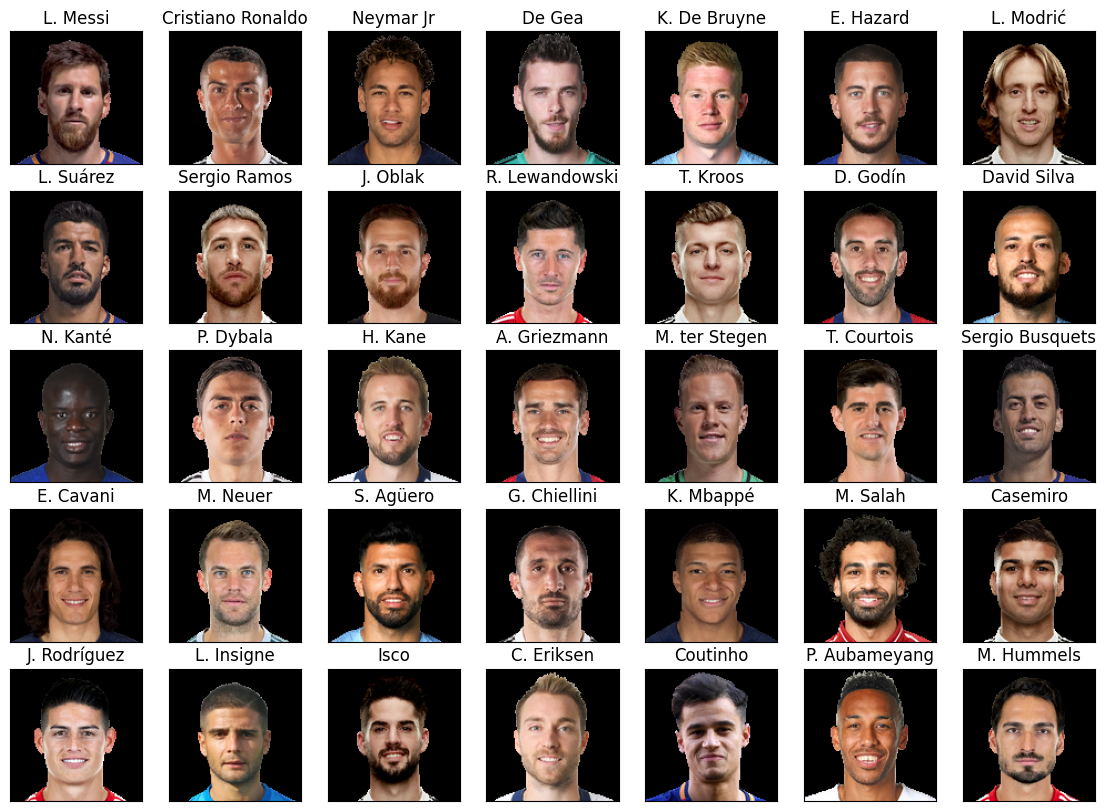

In [4]:
imgs = [img.permute(1,2,0) for img in f]
show_images(imgs,5,7, scale=2,titles = names);

In [16]:
class FIFADataset(torch.utils.data.Dataset):
    def __init__(self, img_list, labels, names):
        super(FIFADataset, self).__init__()
        self.img_list = img_list
        self.labels = labels
        self.names = names
        self.transform = torchvision.transforms.Resize((64,64))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]/255.0
        l  = self.labels[idx]
        n  = self.names[idx]
        return self.transform(img.type(torch.float32)), l, n

In [17]:
fifa = FIFADataset(f,l,names)
batch_size = 256
data_iter = torch.utils.data.DataLoader(
    fifa, batch_size=batch_size,
    shuffle=True, num_workers=2)

##Modelo

### Ejercicio 1



En esta actividad, crearás dos bloques de construcción de redes neuronales personalizadas utilizando PyTorch. Estos bloques, denominados `AUG_block` y `DEC_block`, serán componentes reutilizables que implementan capas de convolución transpuesta y convolución estándar respectivamente, junto con normalización por lotes y funciones de activación. Sigue los pasos a continuación para crear las clases:

1. **Importar las bibliotecas necesarias**: Asegúrate de importar las bibliotecas PyTorch, incluyendo los módulos `nn` y `functional`.

2. **Definir la clase `AUG_block`**:
   - La clase debe heredar de `nn.Module`.
   - En el método `__init__`, inicializa una capa de convolución transpuesta (`nn.ConvTranspose2d`), una capa de normalización por lotes (`nn.BatchNorm2d`) y una función de activación ReLU (`nn.ReLU`).
   - Define el método `forward` para aplicar estas capas en secuencia: convolución transpuesta, normalización por lotes y activación ReLU.

3. **Definir la clase `DEC_block`**:
   - La clase debe heredar de `nn.Module`.
   - En el método `__init__`, inicializa una capa de convolución (`nn.Conv2d`), una capa de normalización por lotes (`nn.BatchNorm2d`) y una función de activación LeakyReLU (`nn.LeakyReLU`).
   - Define el método `forward` para aplicar estas capas en secuencia: convolución, normalización por lotes y activación LeakyReLU.

4. **Parámetros de las clases**:
   - Ambas clases deben aceptar los siguientes parámetros en el método `__init__`: `out_channels`, `in_channels` (por defecto 3), `kernel_size` (por defecto 4), `strides` (por defecto 2) y `padding` (por defecto 1).
   - La clase `DEC_block` debe aceptar un parámetro adicional `alpha` para la activación LeakyReLU (por defecto 0.2).

Asegúrate de seguir las instrucciones y verificar tu código para garantizar que funcione correctamente. ¡Buena suerte!

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AUG_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(AUG_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

class DEC_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(DEC_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

### Ejercicio 2



En esta actividad, crearás una clase denominada `Variational_Encoder` utilizando PyTorch. Esta clase implementará un codificador variacional que incluye varias capas convolucionales seguidas de capas lineales para calcular la media y la varianza logarítmica de la distribución latente. Sigue los pasos a continuación para crear la clase:

1. **Importar las bibliotecas necesarias**: Asegúrate de importar las bibliotecas PyTorch, incluyendo los módulos `nn` y `functional`.

2. **Definir el número de canales de salida inicial `n_G`**: Este valor será utilizado en las capas convolucionales.

3. **Definir la clase `Variational_Encoder`**:
   - La clase debe heredar de `nn.Module`.
   - En el método `__init__`, inicializa una secuencia convolucional (`conv_seq`) utilizando bloques `DEC_block` y capas adicionales:
     - Cinco bloques `DEC_block` con canales de salida incrementales (se duplican en cada bloque).
     - Una capa `nn.AdaptiveMaxPool2d` para reducir la dimensionalidad espacial.
     - Una capa `nn.Flatten` para aplanar el tensor resultante.
     - Una capa `nn.LazyLinear` para transformar los datos a la dimensión latente.
   - Inicializa dos capas lineales adicionales (`linear3` y `linear4`) usando `nn.LazyLinear` para calcular la media y la varianza logarítmica de la distribución latente.

4. **Definir el método `forward`**:
   - Aplica la secuencia convolucional a la entrada `x` para obtener `z`.
   - Calcula la media (`media`) utilizando una capa lineal.
   - Calcula la varianza logarítmica (`log_var`) utilizando otra capa lineal seguida de una activación ReLU.
   - Calcula la desviación estándar (`std`) tomando la exponencial de `0.5 * log_var`.
   - Genera un tensor de ruido `eps` con la misma forma que `std`.
   - Calcula el vector latente (`latente`) utilizando la fórmula `eps * std + media`.
   - Retorna una tupla con el vector latente, la media y la varianza logarítmica.


In [40]:
n_G = 48

class Variational_Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Variational_Encoder, self).__init__()
        self.conv_seq = nn.Sequential(
            DEC_block(n_G),
            DEC_block(in_channels=n_G, out_channels=n_G*2),
            DEC_block(in_channels=n_G*2, out_channels=n_G*4),
            DEC_block(in_channels=n_G*4, out_channels=n_G*8),
            DEC_block(in_channels=n_G*8, out_channels=n_G*16),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.LazyLinear(latent_dims)
        )
        self.linear3 = nn.LazyLinear(latent_dims)
        self.linear4 = nn.LazyLinear(latent_dims)

    def forward(self, x):
        z = self.conv_seq(x)
        media = self.linear3(z)
        log_var = F.relu(self.linear4(z))
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        latente = eps.mul(std).add_(media)
        return (latente, media, log_var)

### Ejercicio 3



En esta actividad, crearás una clase denominada `Decoder` utilizando PyTorch. Esta clase implementará un decodificador que incluye capas convolucionales transpuestas y capas lineales para transformar un vector latente en una imagen reconstruida. Sigue los pasos a continuación para crear la clase:

1. **Importar las bibliotecas necesarias**: Asegúrate de importar las bibliotecas PyTorch, incluyendo los módulos `nn` y `functional`.

2. **Definir el número de canales de salida inicial `n_G`**: Este valor será utilizado en las capas convolucionales transpuestas.

3. **Definir la clase `Decoder`**:
   - La clase debe heredar de `nn.Module`.
   - En el método `__init__`, inicializa una secuencia (`self.seq`) utilizando bloques `AUG_block` y capas adicionales:
     - 4 bloques `AUG_block` con canales de salida decrecientes (se reducen a la mitad en cada bloque).
     - Una capa `nn.ConvTranspose2d` para transformar los datos a una imagen con 3 canales de salida. En este caso, tiene un tamaño de kernel de 4, un paso (stride) de 2 y un padding de 1.
     - Una capa de activación `nn.Sigmoid` para escalar los valores de salida al rango [0, 1].

4. **Definir el método `forward`**:
   - Aplica la secuencia de capas `self.seq` a la entrada `z` para obtener la imagen reconstruida.

In [58]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.seq = nn.Sequential(
          AUG_block(in_channels=latent_dims, out_channels=n_G*8,
                  strides=1, padding=0),
          AUG_block(in_channels=n_G*8, out_channels=n_G*4),
          AUG_block(in_channels=n_G*4, out_channels=n_G*2),
          AUG_block(in_channels=n_G*2, out_channels=n_G),
          nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                            kernel_size=4, stride=2, padding=1, bias=False),
          nn.Sigmoid()
        )


    def forward(self, z):
        return self.seq(z)

### Entrenamiento

In [10]:
class Variational_Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Variational_Autoencoder, self).__init__()
        self.encoder = Variational_Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z, media, log_var = self.encoder(x)
        z = z.unsqueeze(2).unsqueeze(3)
        return self.decoder(z), media, log_var

In [19]:
import torch.nn.functional as F

def vae_loss(x, x_hat, media, log_var):
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    latent_loss = -0.5 * torch.sum(1 + log_var - log_var.exp() - media.pow(2))
    return reconstruction_loss + latent_loss

In [38]:
def train(autoencoder, data, epochs=40):
    opt = torch.optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        L = 0.0
        N = 0
        for x, _, _ in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat, media, std = autoencoder(x)
            l = vae_loss(x,x_hat, media, std)
            l.backward()
            opt.step()
            L += l.sum()
            N += l.numel()
        print(f'epoch {epoch + 1}, loss {(L/N):f}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dims = 500
vae = Variational_Autoencoder(latent_dims).to(device) # GPU

train(vae, data_iter)

epoch 1, loss 1182861.000000
epoch 2, loss 945162.250000
epoch 3, loss 924087.250000
epoch 4, loss 912817.375000
epoch 5, loss 905668.875000
epoch 6, loss 901150.625000
epoch 7, loss 898533.625000
epoch 8, loss 896442.062500
epoch 9, loss 893805.687500
epoch 10, loss 890599.437500
epoch 11, loss 888857.562500
epoch 12, loss 887577.312500
epoch 13, loss 886176.000000
epoch 14, loss 885309.250000
epoch 15, loss 884380.375000
epoch 16, loss 883641.250000
epoch 17, loss 883292.687500
epoch 18, loss 882399.437500
epoch 19, loss 882224.000000
epoch 20, loss 881339.937500
epoch 21, loss 880793.062500
epoch 22, loss 880499.750000
epoch 23, loss 879989.750000
epoch 24, loss 879755.937500
epoch 25, loss 879444.687500
epoch 26, loss 878928.187500
epoch 27, loss 878668.437500
epoch 28, loss 878480.000000
epoch 29, loss 877905.687500
epoch 30, loss 878011.875000
epoch 31, loss 877591.062500
epoch 32, loss 877612.687500
epoch 33, loss 876794.625000
epoch 34, loss 876854.875000
epoch 35, loss 876709.

## Interpolación

### Ejercicio 4



En esta actividad, implementarás una función denominada `model_interp` utilizando PyTorch. Esta función generará una interpolación lineal entre dos imágenes comprimidas por un modelo de autoencoder variacional y luego decodificará estas interpolaciones para obtener nuevas imágenes. Sigue los pasos a continuación para crear la función:

1. **Definir la función `model_interp`**:
   - La función debe aceptar cuatro parámetros:
     - `model`: el modelo de autoencoder variacional que será utilizado.
     - `index1`: el índice de la primera imagen en el conjunto de datos.
     - `index2`: el índice de la segunda imagen en el conjunto de datos.
     - `size` (opcional, por defecto 10): el número de interpolaciones que deseas generar entre las dos imágenes.

2. **Obtener las imágenes del conjunto de datos**:
   - Usa los índices `index1` y `index2` para obtener las dos imágenes del conjunto de datos `fifa`.
   - Transfiere las imágenes al dispositivo adecuado (`device`) y agrega una dimensión adicional para que sean compatibles con el modelo.

3. **Codificar las imágenes**:
   - Pasa las dos imágenes a través del codificador del modelo para obtener sus representaciones comprimidas (`img1_compressed` y `img2_compressed`).

4. **Generar interpolaciones**:
   - Utiliza una función auxiliar `get_interp` (que se da implementada) para generar una interpolación lineal entre las dos representaciones comprimidas.

5. **Preparar las interpolaciones para el decodificador**:
   - Convierte las interpolaciones generadas a un tensor de PyTorch.
   - Ajusta las dimensiones del tensor para que sean compatibles con el decodificador del modelo.

6. **Decodificar las interpolaciones**:
   - Pasa las interpolaciones a través del decodificador del modelo para obtener las imágenes artificiales generadas.

7. **Retornar las imágenes generadas**.


Asegúrate de seguir las instrucciones y verificar tu código para garantizar que funcione correctamente. ¡Buena suerte!

In [28]:
import numpy as np

def get_interp(v1, v2, n):
  if not v1.shape == v2.shape:
    raise Exception('Different vector size')

  v1 = v1.to("cpu")
  v2 = v2.to("cpu")

  return np.array([np.linspace(v1[i], v2[i], n+2) for i in range(v1.shape[0])]).T



def model_interp(model, index1, index2, size = 10):

    image1 = fifa[index1][0].to(device).unsqueeze(0)
    image2 = fifa[index2][0].to(device).unsqueeze(0)

    img1_compressed,_,_ = model.encoder(image1)
    img2_compressed,_,_ = model.encoder(image2)

    interp = get_interp(img1_compressed.detach(), img2_compressed.detach(), size)

    interp = torch.from_numpy(interp)

    interp = interp.permute(1,0,2).unsqueeze(3).to(device)

    print(interp.shape)

    artificial_images = model.decoder(interp)

    return artificial_images





torch.Size([12, 500, 1, 1])


torch.Size([12, 3, 64, 64])

In [ ]:
# @title Función para mostrar resultados
def show_interp(imgs, index1, index2, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (12 * scale, 1 * scale)
    _, axes = plt.subplots(1, 12, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach().numpy()
        except:
            pass
        if i==0:
            ax.set_title(titles[index1])
            ax.imshow(fifa[index1][0].permute(1,2,0).cpu().detach().numpy())
        elif i==11:
            ax.set_title(titles[index2])
            ax.imshow(fifa[index2][0].permute(1,2,0).cpu().detach().numpy())
        else:
          ax.imshow(img)
          ax.axes.get_xaxis().set_visible(False)
          ax.axes.get_yaxis().set_visible(False)
    return axes

torch.Size([12, 500, 1, 1])


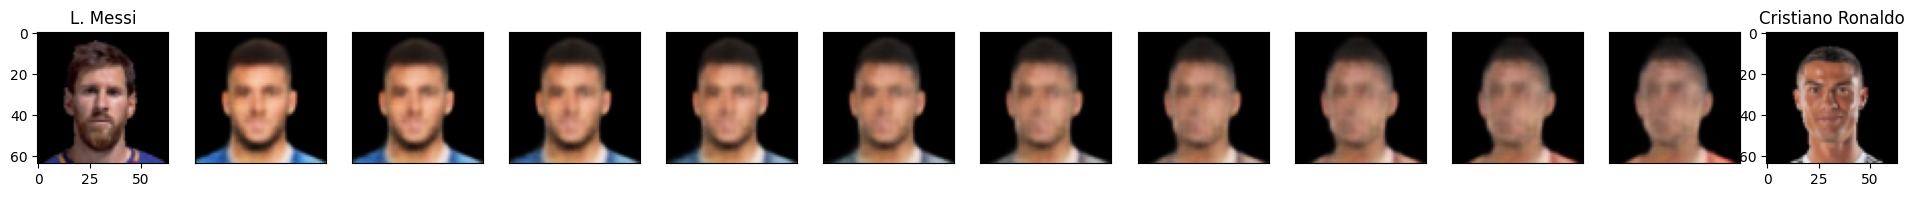

In [55]:
index1 = 0
index2 = 1
interp_result = model_interp(model = vae, index1 = index1, index2 = index2).unbind(0)
imgs = [img.permute(1,2,0).cpu() for img in interp_result]
show_interp(imgs,index1,index2, scale=2, titles = names);